# Sentence-level relation extraction with classic ML and LLM methods

## Dataset loading and review

In this experiment will be used dataset [SemEval 2010 Task 8](https://paperswithcode.com/dataset/semeval-2010-task-8). This dataset is open-sourced for anyone.

In [15]:
! pip install pandas pyarrow fsspec huggingface_hub

  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached PyYAML-6.0.2-cp311-cp311-macosx_11_0_arm64.whl.metadata (2.1 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached charset_normalizer-3.4.1-cp311-cp311-macosx_10_9_universal2.whl.metadata (35 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached certifi-2025.1.31-py3-none-any.whl.metadata (2.5 kB)
Using cached PyYAML-6.0.2-cp311-cp311-macosx_11_0_arm64.whl (172 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached filelock-3.18.0-py3-none-any.whl (16 kB)
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
Using cached certifi-2025.1.31-py3-none-any.whl (166 kB)
Using cached charset_normalizer-3.4.1-cp311-cp311-macosx_10_9_universal2.whl (194 kB)
Using cached idna-3.10-py3-none-any.whl (70 kB)


In [16]:
import pandas as pd

splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/SemEvalWorkshop/sem_eval_2010_task_8/" + splits["train"])

/opt/anaconda3/envs/practice_2025/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
df.head()

,sentence,relation
0,The system as described above has its greatest...,3
1,The <e1>child</e1> was carefully wrapped and b...,18
2,The <e1>author</e1> of a keygen uses a <e2>dis...,11
3,A misty <e1>ridge</e1> uprises from the <e2>su...,18
4,The <e1>student</e1> <e2>association</e2> is t...,12


In [21]:
df['sentence'][0]

'The system as described above has its greatest application in an arrayed <e1>configuration</e1> of antenna <e2>elements</e2>.'

In [24]:
len(df.relation.unique())

19

There are 19 unique types of relation in this dataset labels:

0 - Cause-Effect(e1,e2)

1 - Cause-Effect(e2,e1)

2 - Component-Whole(e1,e2)

3 - Component-Whole(e2,e1)

4 - Content-Container(e1,e2)

5 - Content-Container(e2,e1)

6 - Entity-Destination(e1,e2)

7 - Entity-Destination(e2,e1)

8 - Entity-Origin(e1,e2)

9 - Entity-Origin(e2,e1)

10 - Instrument-Agency(e1,e2)

11 - Instrument-Agency(e2,e1)

12 - Member-Collection(e1,e2)

13 - Member-Collection(e2,e1)

14 - Message-Topic(e1,e2)

15 - Message-Topic(e2,e1)

16 - Product-Producer(e1,e2)

17 - Product-Producer(e2,e1)

18 - Other


**18 number is used when there is no relation or relation is not of present types**

# Brief task description

Using the **classic ML** method we give the model vectors of features as the input. Model expected to return the predicted class of relations for every item.

Features will be extracted manually with special functions before vectorizing and data splitting.

Vectorizing will be done with TF-IDF-Vectorizer as it's one of the most used classic vectorizers. As the output we expect to have the array of numbers, each showing the relation type for it's sentence.

## Features extracting

In the paper 'SemEval-2010 Task 8: Multi-Way Classification of Semantic Relations Between Pairs of Nominals' there was a set of features extractred to determine the type of relation.

Features:
- **Words between entities:** text between e1 and e2.

- **Parts of speech (POS tags):** definition of grammatical categories of words.

- **Syntactic dependencies:** relationships between words in a sentence.

- **Named entity types (NERs):** categories to which entities belong (e.g., organization, location).

For using RandomForest as classic ML method it is also required to split text in a set of features, so let's write functions that will extract these features from text

In [51]:
def get_words_between_entities(text: str) -> str:
    e1_start = text.find('<e1>')
    e1_end = text.find('</e1>')
    e2_start = text.find('<e2>')
    e2_end = text.find('</e2>')

    clean_text = text.replace('<e1>', '').replace('</e1>', '')
    clean_text = clean_text.replace('<e2>', '').replace('</e2>', '')

    if e1_end < e2_start:
        between = text[e1_end+5 : e2_start]
    else:
        between = text[e2_end+5 : e1_start]

    return between.strip()

In [52]:
df['sentence'][0], get_words_between_entities(df['sentence'][0])

('The system as described above has its greatest application in an arrayed <e1>configuration</e1> of antenna <e2>elements</e2>.',
 'of antenna')

In [32]:
! pip install spacy
! python -m spacy download en_core_web_sm

  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Using cached wasabi-1.1.3-py3-none-any.whl.metadata (28 kB)
  Using cached srsly-2.5.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (19 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached weasel-0.4.1-py3-none-any.whl.metadata (4.6 kB)
  Using cached typer-0.15.2-py3-none-any.whl.metadata (15 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached langcodes-3.5.0-py3-none-any.whl.metadata (29 kB)
  Using cached language_data-1.3.0-py3-none-any.whl.metadata (4.3 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached confection-0.1.5-py3-none-any.whl.metadata (19 kB)
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached cloudpathlib-0.21.0-py3-none-any.whl.metad

In [33]:
import spacy
import re

nlp = spacy.load("en_core_web_sm")

def get_pos_tags_between_entities(text: str) -> list:
    clean_text = text.replace("<e1>", "").replace("</e1>", "").replace("<e2>", "").replace("</e2>", "")

    pattern1 = r"<e1>(.*?)</e1>.*?<e2>(.*?)</e2>"
    pattern2 = r"<e2>(.*?)</e2>.*?<e1>(.*?)</e1>"

    if re.search(pattern1, text):
        between = text.split('</e1>')[1].split('<e2>')[0]
    elif re.search(pattern2, text):
        between = text.split('</e2>')[1].split('<e1>')[0]
    else:
        return []

    between = between.strip()
    doc = nlp(between)
    return [token.pos_ for token in doc]

In [43]:
df['sentence'][0], get_pos_tags_between_entities(df['sentence'][0])

('The system as described above has its greatest application in an arrayed <e1>configuration</e1> of antenna <e2>elements</e2>.',
 ['ADP', 'NOUN'])

In [45]:
import spacy
import re

nlp = spacy.load("en_core_web_sm")

def get_dependency_path_between_entities(text: str) -> list:

    e1 = re.search(r"<e1>(.*?)</e1>", text).group(1)
    e2 = re.search(r"<e2>(.*?)</e2>", text).group(1)
    clean_text = re.sub(r"</?e[12]>", "", text)

    doc = nlp(clean_text)

    token_e1 = next((t for t in doc if t.text == e1), None)
    token_e2 = next((t for t in doc if t.text == e2), None)

    if not token_e1 or not token_e2:
        return []

    def get_ancestors(token):
        return list(token.ancestors)

    ancestors_e1 = [token_e1] + get_ancestors(token_e1)
    ancestors_e2 = [token_e2] + get_ancestors(token_e2)

    common = set(ancestors_e1) & set(ancestors_e2)
    if not common:
        return []

    lca = next(t for t in ancestors_e1 if t in common)

    path_e1 = []
    curr = token_e1
    while curr != lca:
        path_e1.append(curr.dep_)
        curr = curr.head

    path_e2 = []
    curr = token_e2
    while curr != lca:
        path_e2.append(curr.dep_)
        curr = curr.head

    return path_e1 + [lca.dep_] + list(reversed(path_e2))

In [46]:
df['sentence'][0], get_dependency_path_between_entities(df['sentence'][0])

('The system as described above has its greatest application in an arrayed <e1>configuration</e1> of antenna <e2>elements</e2>.',
 ['pobj', 'prep', 'pobj'])

In [47]:
import spacy
import re

nlp = spacy.load("en_core_web_sm")

def get_entity_ner_types(text: str) -> tuple:

    e1_match = re.search(r"<e1>(.*?)</e1>", text)
    e2_match = re.search(r"<e2>(.*?)</e2>", text)
    if not e1_match or not e2_match:
        return ("O", "O")

    e1_text = e1_match.group(1)
    e2_text = e2_match.group(1)

    clean_text = re.sub(r"</?e[12]>", "", text)
    doc = nlp(clean_text)

    e1_type = "O"
    e2_type = "O"

    for ent in doc.ents:
        if ent.text == e1_text:
            e1_type = ent.label_
        if ent.text == e2_text:
            e2_type = ent.label_

    return (e1_type, e2_type)

In [48]:
df['sentence'][0], get_entity_ner_types(df['sentence'][0])

('The system as described above has its greatest application in an arrayed <e1>configuration</e1> of antenna <e2>elements</e2>.',
 ('O', 'O'))

### Extracting features for every text and adding to dataset

In [71]:
df['words between entities'] = [get_words_between_entities(text) for text in df['sentence']]
df['pos tags'] = [get_pos_tags_between_entities(text) for text in df['sentence']]
df['syntactic dependencies'] = [get_dependency_path_between_entities(text) for text in df['sentence']]
df['ner types'] = [get_entity_ner_types(text) for text in df['sentence']]

In [72]:
df.head()

,sentence,relation,words between entities,pos tags,syntatic dependencies,ner types,syntactic dependencies
0,The system as described above has its greatest...,3,of antenna,"[ADP, NOUN]","[pobj, prep, pobj]","(O, O)","[pobj, prep, pobj]"
1,The <e1>child</e1> was carefully wrapped and b...,18,was carefully wrapped and bound into the,"[AUX, ADV, VERB, CCONJ, VERB, ADP, PRON]","[nsubjpass, ROOT, conj, prep, pobj]","(O, O)","[nsubjpass, ROOT, conj, prep, pobj]"
2,The <e1>author</e1> of a keygen uses a <e2>dis...,11,of a keygen uses a,"[ADP, DET, NOUN, VERB, PRON]","[nsubj, ROOT, dobj]","(O, O)","[nsubj, ROOT, dobj]"
3,A misty <e1>ridge</e1> uprises from the <e2>su...,18,uprises from the,"[NOUN, ADP, PRON]","[compound, ROOT, prep, pobj]","(O, O)","[compound, ROOT, prep, pobj]"
4,The <e1>student</e1> <e2>association</e2> is t...,12,,[],"[compound, nsubj]","(O, O)","[compound, nsubj]"


## Vectorizing and splitting

In [84]:
! pip install scipy sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
    

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

def vectorize_features(df, feature_columns):

    matrices = []
    vectorizers = {}

    for col in feature_columns:
        processed = df[col].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))
        vec = TfidfVectorizer()
        X_col = vec.fit_transform(processed)
        matrices.append(X_col)
        vectorizers[col] = vec

    X = hstack(matrices)
    return X, vectorizers

In [94]:
cols = ['words between entities', 'pos tags', 'syntactic dependencies', 'ner types']
X, vectorizers = vectorize_features(df, cols)

In [102]:
from sklearn.model_selection import train_test_split

y = df['relation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model learning and predicting

In [103]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [104]:
y_pred = clf.predict(X_test)

In [105]:
! pip install matplotlib

In [111]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.818     0.738     0.776        61
           1      0.808     0.761     0.784       138
           2      0.742     0.720     0.731       100
           3      0.492     0.299     0.372        97
           4      0.756     0.739     0.747        88
           5      0.643     0.429     0.514        42
           6      0.751     0.899     0.818       158
           8      0.586     0.794     0.675       107
           9      0.385     0.345     0.364        29
          10      0.417     0.357     0.385        14
          11      0.750     0.600     0.667        85
          12      1.000     0.235     0.381        17
          13      0.681     0.916     0.781       119
          14      0.671     0.553     0.606       103
          15      0.818     0.310     0.450        29
          16      0.571     0.364     0.444        66
          17      0.500     0.437     0.466        87
          18      0.306    

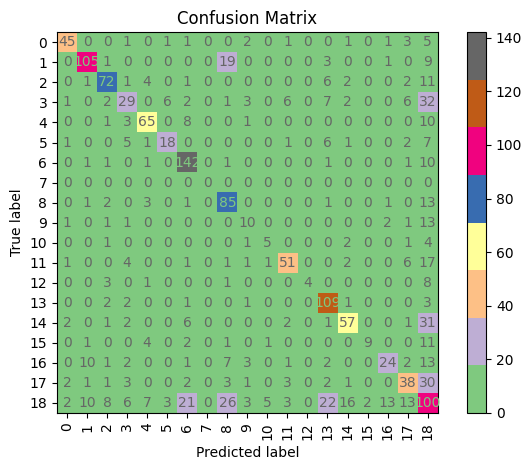

In [110]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = sorted(df['relation'].unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=90, cmap='Accent', values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [112]:
relation_dict = {
    0: 'Cause-Effect(e1,e2)',
    1: 'Cause-Effect(e2,e1)',
    2: 'Component-Whole(e1,e2)',
    3: 'Component-Whole(e2,e1)',
    4: 'Content-Container(e1,e2)',
    5: 'Content-Container(e2,e1)',
    6: 'Entity-Destination(e1,e2)',
    7: 'Entity-Destination(e2,e1)',
    8: 'Entity-Origin(e1,e2)',
    9: 'Entity-Origin(e2,e1)',
    10: 'Instrument-Agency(e1,e2)',
    11: 'Instrument-Agency(e2,e1)',
    12: 'Member-Collection(e1,e2)',
    13: 'Member-Collection(e2,e1)',
    14: 'Message-Topic(e1,e2)',
    15: 'Message-Topic(e2,e1)',
    16: 'Product-Producer(e1,e2)',
    17: 'Product-Producer(e2,e1)',
    18: 'Other'
}

In [114]:
import re

df_test = df_test.reset_index(drop=True)

for i in [0, 1]:
    sentence = df_test.loc[i, 'sentence']
    predicted_relation = y_pred[i]

    e1_match = re.search(r"<e1>(.*?)</e1>", sentence)
    e2_match = re.search(r"<e2>(.*?)</e2>", sentence)
    e1 = e1_match.group(1) if e1_match else "<e1>"
    e2 = e2_match.group(1) if e2_match else "<e2>"

    print("Предложение:", sentence)
    print(f"Граф: {e1} —[{predicted_relation}: {relation_dict[predicted_relation]}]→ {e2}")
    print()

Предложение: The inhabitants send messages to each other by placing the <e1>message</e1> in a <e2>capsule</e2> and placing the capsule in a message tube.
Граф: message —[4: Content-Container(e1,e2)]→ capsule

Предложение: I placed the <e1>cache</e1> in a natural <e2>cavity</e2>, at the base of a part of the fallen arch.
Граф: cache —[6: Entity-Destination(e1,e2)]→ cavity

